**Name:** Tan Wan Xuen <br>
**Student ID:** 2207214  <br>
**Project Title:** Machine Learning-Driven Predictive Loan Repayment behaviour <br>
**Notebook:** Data Extracction <br>
**Overview:**  Freddie Mac's Single-Family Loan-Level Dataset provides loan-level credit performance data for all mortgages. In this notebook, the useful features in the historical data for the year 2023 are extracted and saved as Parquet file.
<br><br>
**Content:**<br>
1.0 Read text files <br>
2.0 Merge datasets based on the loan ID <br>
3.0 Obtain 2023 dataset <br>
4.0 Feature selection based on coverage ratio <br>
5.0 Correlation between numerical variables <br>
6.0 Correlation between categorical variables <br>
7.0 Get target variable <br>
8.0 Check and remove duplicates <br>
9.0 Examine dataset <br>
10.0 Save desired dataset

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from joblib import Parallel, delayed

In [2]:
# File paths
RESOURCES_DIR_2023_Q1 = "../resources/historical_data_2023/historical_data_2023Q1"
RESOURCES_DIR_2023_Q2 = "../resources/historical_data_2023/historical_data_2023Q2"
RESOURCES_DIR_2023_Q3 = "../resources/historical_data_2023/historical_data_2023Q3"
RESOURCES_DIR_2023_Q4 = "../resources/historical_data_2023/historical_data_2023Q4"

# mp stands for monthly performance data
MP_COL = ["loan_sequence_num", "monthly_reporting_period", "cur_actual_UPB", "cur_LDS", "loan_age",
          "remaining_mths_to_legal_maturity", "defect_settlement_date", "modification_flag", "zero_bal_code",
          "zero_bal_effective_date", "cur_int_rate", "cur_deferred_UPB", "DDLPI", "MI_recover",
          "net_sales_proceeds", "non_MI_recover", "expenses", "legal_costs", "MPC", "taxes_and_insurance",
          "miscel_expenses", "actual_loss_calculation", "modification_cost", "step_mod_flag", "deferred_pay_plan",
          "ELTV", "zero_bal_removal_UPB", "del_accrued_int", "del_due_to_disaster", "BASC", "cur_mth_mod_cost",
          "int_bearing_UPB"]

# ori stands for origination data
ORI_COL = ["credit_score", "first_payment_date", "first_time_homebuyer", "maturity_date", 
           "MSA", "MI(%)", "num_of_units", "occupancy_status", "ori_CLTV", "ori_DTI", "ori_UPB", 
           "ori_LTV", "ori_int_rate", "channel", "PPM_flag", "amorisation_type", "property_state",
           "property_type", "postal_code", "loan_sequence_num", "loan_purpose", "ori_loan_term", 
           "num_borrowers", "seller_name", "servicer_name", "super_conforming_flag", "pre-HARP_LSN",
           "program_indicator", "HARP_indicator", "property_valuation_method", "I/O_indicator", "MICI"]

QUARTER_COL = "quarter"

In [3]:
# To load and convert all the text files into csv files
def load_file(file_path, filename, col_name):
    file = os.path.join(file_path, filename)
    dtype_to_map={'del_due_to_disaster': 'object', 'modification_flag': 'object', 
                  'step_mod_flag': 'object', 'super_conforming_flag': 'object', 
                  'program_indicator': 'object', 'BASC': 'object', 'cur_LDS': 'object',
                  'deferred_pay_plan': 'object'}
    ddf = dd.read_csv(os.path.normpath(file), delimiter="|", names=col_name, skipinitialspace=True, 
                      assume_missing=True, dtype=dtype_to_map)
    return ddf

# To merge the datasets 
def merge_data(df_mp, df_ori):
    ddf = dd.merge(df_mp, df_ori, on="loan_sequence_num", how="left")
    return ddf

## 1.0 Read text files

In [4]:
# Monthly Performance Datasets
Q1_23_mp = load_file(RESOURCES_DIR_2023_Q1, "historical_data_time_2023Q1.txt", MP_COL)
Q2_23_mp = load_file(RESOURCES_DIR_2023_Q2, "historical_data_time_2023Q2.txt", MP_COL)
Q3_23_mp = load_file(RESOURCES_DIR_2023_Q3, "historical_data_time_2023Q3.txt", MP_COL)
Q4_23_mp = load_file(RESOURCES_DIR_2023_Q4, "historical_data_time_2023Q4.txt", MP_COL)

# Origination Datasets
Q1_23_ori = load_file(RESOURCES_DIR_2023_Q1, "historical_data_2023Q1.txt", ORI_COL)
Q2_23_ori = load_file(RESOURCES_DIR_2023_Q2, "historical_data_2023Q2.txt", ORI_COL)
Q3_23_ori = load_file(RESOURCES_DIR_2023_Q3, "historical_data_2023Q3.txt", ORI_COL)
Q4_23_ori = load_file(RESOURCES_DIR_2023_Q4, "historical_data_2023Q4.txt", ORI_COL)

## 2.0 Merge datasets based on the loan ID

In [5]:
Q1_2023 = merge_data(Q1_23_mp, Q1_23_ori)
Q2_2023 = merge_data(Q2_23_mp, Q2_23_ori)
Q3_2023 = merge_data(Q3_23_mp, Q3_23_ori)
Q4_2023 = merge_data(Q4_23_mp, Q4_23_ori)

## 3.0 Obtain 2023 dataset 

In [6]:
Q1_2023[QUARTER_COL] = "1"
Q2_2023[QUARTER_COL] = "2"
Q3_2023[QUARTER_COL] = "3"
Q4_2023[QUARTER_COL] = "4"

In [7]:
ddf = dd.concat([Q1_2023, Q2_2023, Q3_2023, Q4_2023], axis=0)  

In [8]:
ddf.shape

(<dask_expr.expr.Scalar: expr=(Concat(frames=[Assign(frame=Merge(462b7df)), Assign(frame=Merge(25eb3fa)), Assign(frame=Merge(e74aece)), Assign(frame=Merge(1a6688c))], )).size() // 64, dtype=int64>,
 64)

## 4.0 Feature selection based on coverage ratio

In [9]:
# Only select features with coverage ratio greater than 70%
# Meaning that all the columns with more than 30% missing values are removed
def get_high_coverage_ratio_features(ddf_sample, threshold=0.7):
    
    df = ddf_sample.compute()
    coverage_results = []
    
    print("Coverage ratio for each feature:")

    for col in df.columns:
        total_not_null = df[col].notna().sum()  # Count non-null values
        total = df.shape[0]  # Total number of rows
        coverage_ratio = total_not_null / total  # Compute coverage ratio

        if coverage_ratio >= threshold:
            dtype = df[col].dtype
            samples = df[col].dropna().sample(n=min(5, total_not_null)).tolist() if total_not_null > 0 else []
            num_unique_values = df[col].nunique()

            coverage_results.append({
                'column_name': col,
                'coverage_ratio': coverage_ratio,
                'dtype': dtype,
                'samples': samples,
                'total_rows': total,
                'num_unique_values': num_unique_values
            })

    # Sort results by coverage ratio 
    sorted_coverage_results = sorted(coverage_results, key=lambda x: x['coverage_ratio'], reverse=True)

    for result in sorted_coverage_results:
        print(f"\n{result['column_name']}: {result['coverage_ratio']:.2%}")
        print(f"dtype: {result['dtype']}")
        print(f"samples: {result['samples']}")
        print(f"Total rows: {result['total_rows']}")
        print(f"Number of unique values: {result['num_unique_values']}")

    df_result = pd.DataFrame(sorted_coverage_results)
    
    if not df_result.empty:  
        plt.figure(figsize=(min(len(df_result) * 2, 30), 9))
        sns.barplot(data=df_result, x='column_name', y='coverage_ratio', palette='Greens')
        plt.title('Coverage Ratio for Selected Features')
        plt.xlabel('Features')
        plt.ylabel('Coverage Ratio')
        plt.xticks(rotation=90)
        plt.show()

Coverage ratio for each feature:

loan_sequence_num: 100.00%
dtype: string
samples: ['F23Q20052447', 'F23Q10003565', 'F23Q20168212', 'F23Q40032672', 'F23Q30053880']
Total rows: 12983784
Number of unique values: 931731

monthly_reporting_period: 100.00%
dtype: float64
samples: [202308.0, 202401.0, 202406.0, 202401.0, 202310.0]
Total rows: 12983784
Number of unique values: 21

cur_actual_UPB: 100.00%
dtype: float64
samples: [431000.0, 228355.7, 227000.0, 533000.0, 238740.36]
Total rows: 12983784
Number of unique values: 4102156

cur_LDS: 100.00%
dtype: string
samples: ['0', '0', '0', '0', '0']
Total rows: 12983784
Number of unique values: 21

loan_age: 100.00%
dtype: float64
samples: [3.0, 13.0, 7.0, 11.0, 10.0]
Total rows: 12983784
Number of unique values: 21

remaining_mths_to_legal_maturity: 100.00%
dtype: float64
samples: [346.0, 356.0, 343.0, 357.0, 356.0]
Total rows: 12983784
Number of unique values: 332

cur_int_rate: 100.00%
dtype: float64
samples: [7.25, 7.5, 7.5, 6.625, 7.125]


C:\Users\User\AppData\Local\Temp\ipykernel_18036\3401809565.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='column_name', y='coverage_ratio', palette='Greens')


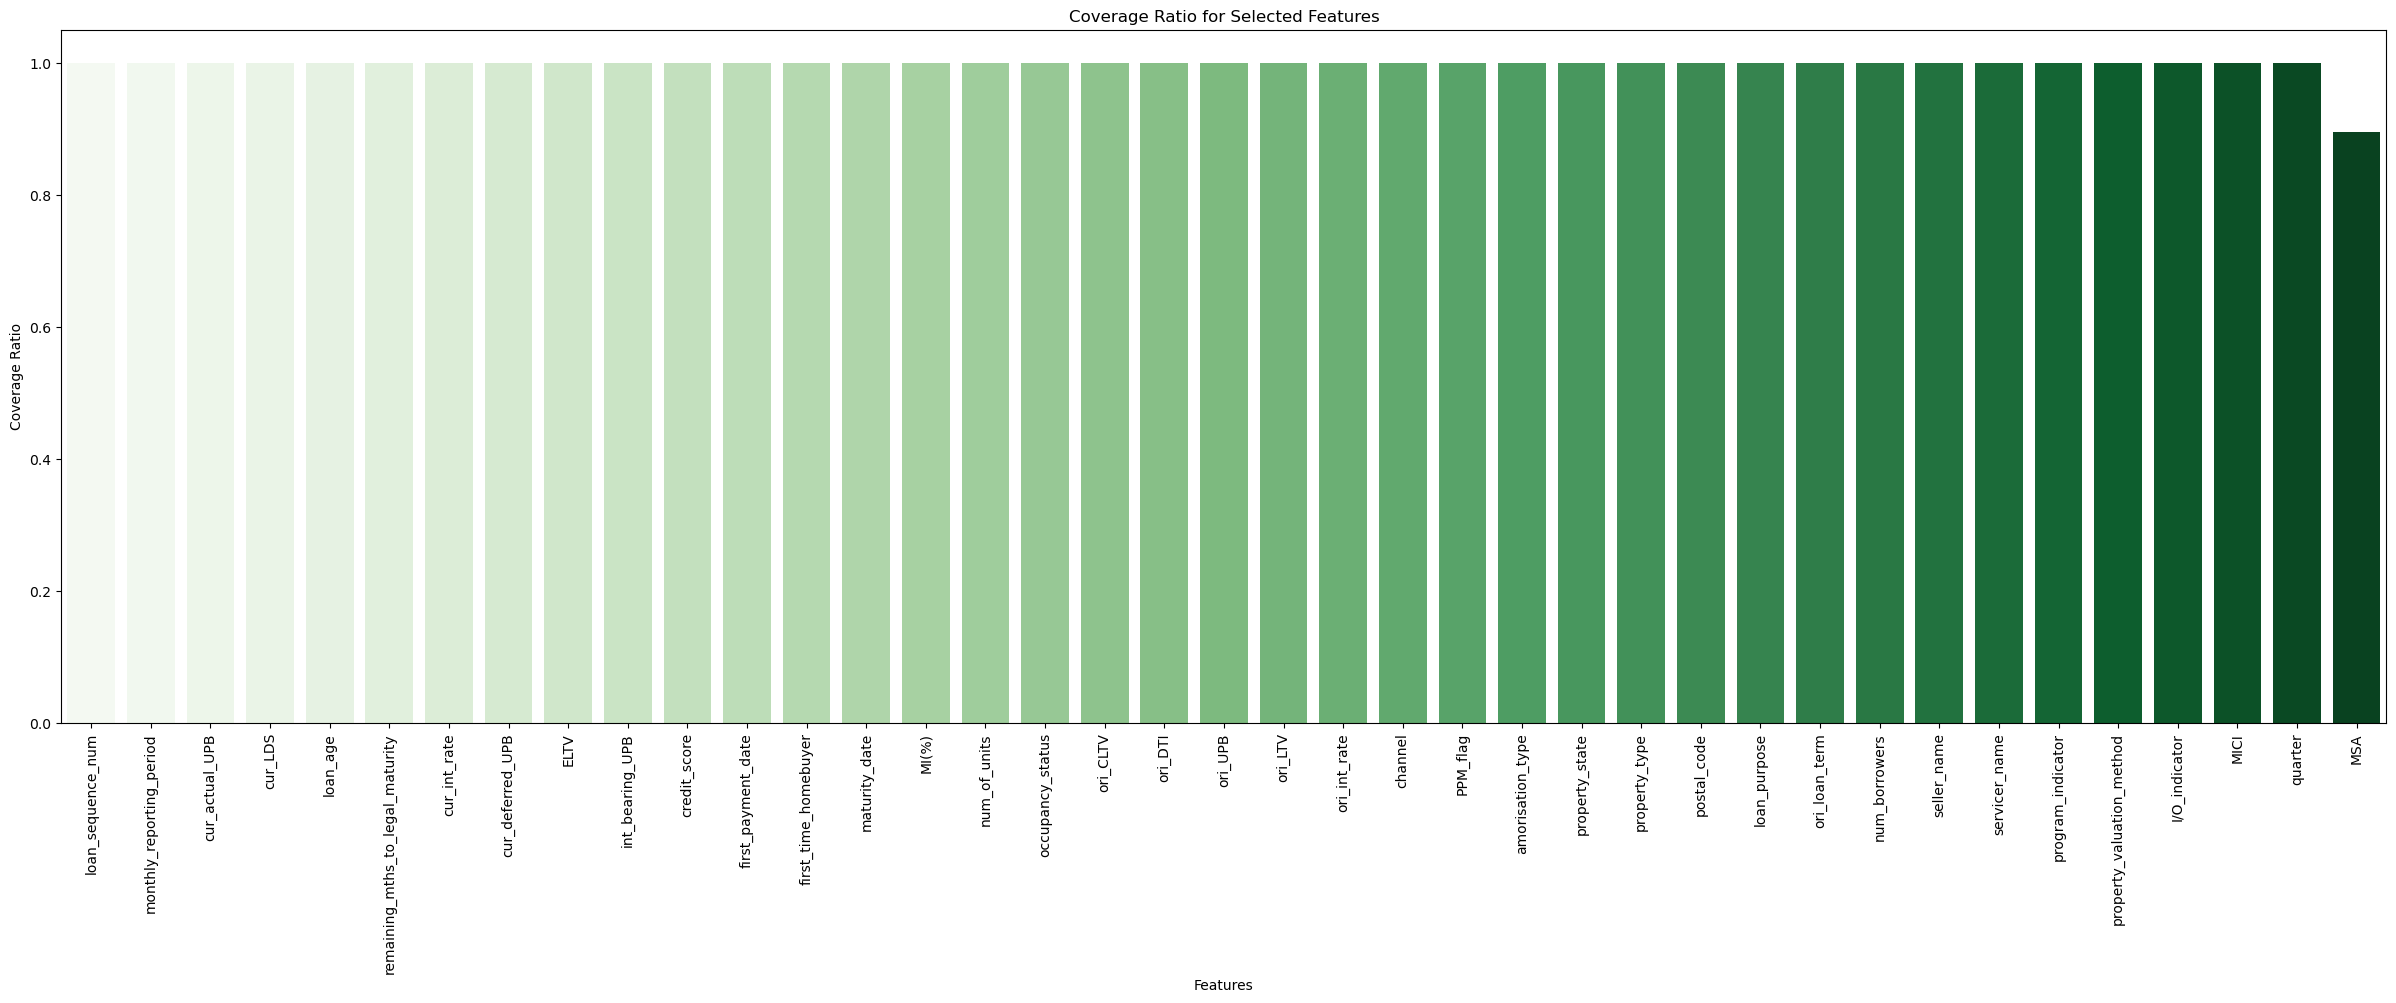

In [10]:
get_high_coverage_ratio_features(ddf)

In [11]:
# Filter the dataset with selected features
ddf = ddf[['loan_sequence_num', 'monthly_reporting_period', 'cur_actual_UPB', 'cur_LDS', 'loan_age', 'remaining_mths_to_legal_maturity',
       'cur_int_rate', 'cur_deferred_UPB', 'ELTV', 'int_bearing_UPB', 'credit_score', 'first_payment_date',
       'first_time_homebuyer', 'maturity_date', 'MI(%)', 'num_of_units', 'occupancy_status', 'ori_CLTV', 
       'ori_DTI', 'ori_UPB', 'ori_LTV', 'ori_int_rate', 'channel', 'PPM_flag', 'amorisation_type', 'property_state',
       'property_type', 'postal_code', 'loan_purpose', 'ori_loan_term', 'num_borrowers', 'seller_name', 'servicer_name',
       'program_indicator', 'property_valuation_method', 'I/O_indicator', 'MICI', 'MSA','quarter']]

## 5.0 Correlation between numerical variables 

Text(0.5, 1.0, 'Correlation Heatmap of Features')

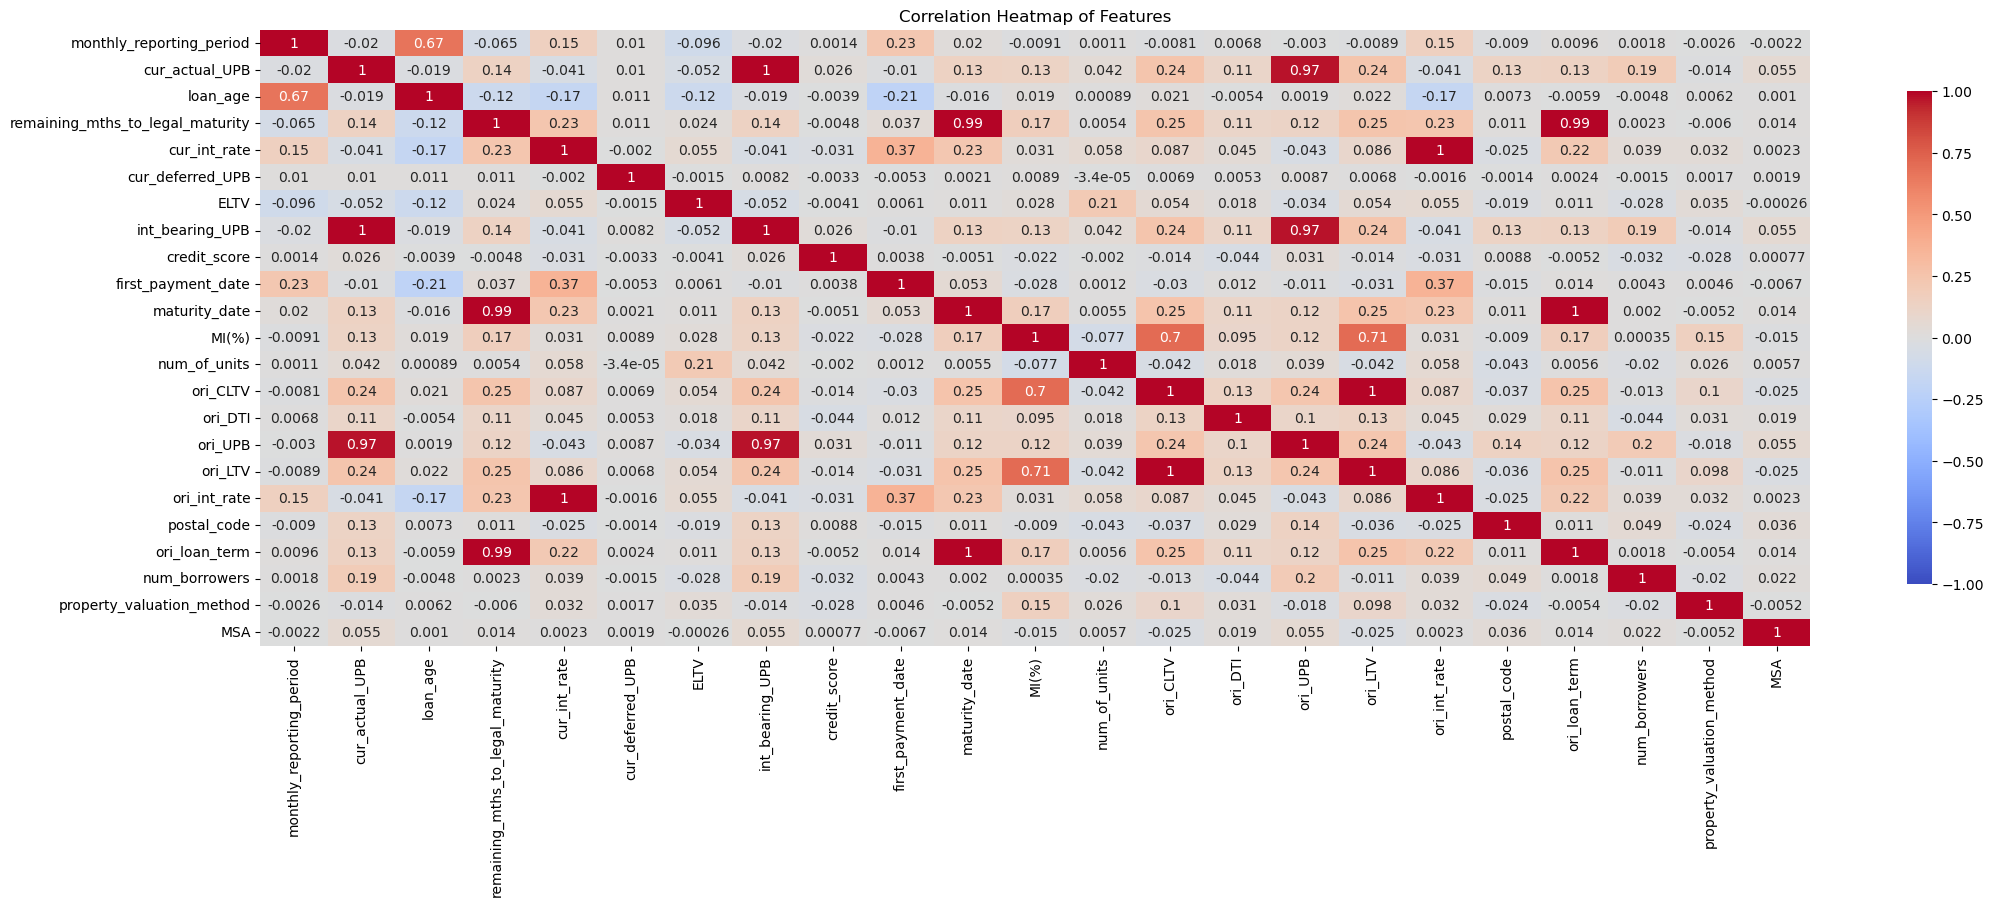

In [12]:
df_numeric = ddf.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr().compute()
fig = plt.subplots(figsize = (25,8))
sns.heatmap(correlation_matrix, vmin = -1, vmax = 1, cmap = "coolwarm", annot = True, cbar_kws={"shrink":.8})
plt.title("Correlation Heatmap of Features")

In [13]:
to_drop = set()  # Set to hold features to drop

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]  # Get column name
            to_drop.add(colname)
df_numeric = df_numeric.drop(columns=to_drop)
print(to_drop)

{'ori_UPB', 'maturity_date', 'ori_loan_term', 'ori_CLTV', 'ori_int_rate', 'ori_LTV', 'int_bearing_UPB'}


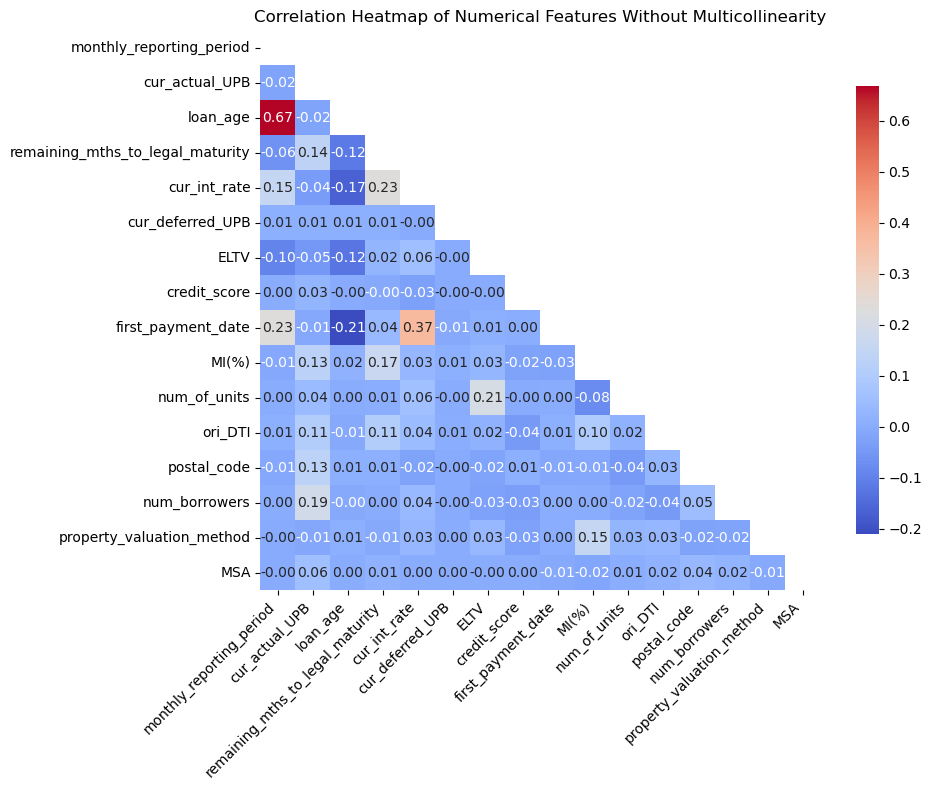

In [14]:
new_correlation_matrix = df_numeric.corr().compute()
mask = np.triu(np.ones_like(new_correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, 
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            square=True,
            cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Features Without Multicollinearity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6.0 Correlation between categorical variables 

In [15]:
# To compute Cramér’s V for categorical variables
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    
    # If only one unique value exists, return NaN
    if contingency_table.shape[0] == 1 or contingency_table.shape[1] == 1:
        return np.nan  
    
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

# To compute Cramér’s V matrix
def cramers_v_matrix(df_cat):
    # Drop columns with only one unique value
    df_cat = df_cat.loc[:, df_cat.nunique() > 1]

    df_cat = df_cat.fillna("NULL")
    
    categorical_columns = df_cat.columns
    n = len(categorical_columns)
    cramers_v_matrix = pd.DataFrame(np.eye(n), index=categorical_columns, columns=categorical_columns)

    def compute_cramers_v(i, j):
        col1, col2 = categorical_columns[i], categorical_columns[j]
        return cramers_v(df_cat[col1], df_cat[col2])

    # Compute only the upper triangle and mirror the values
    results = Parallel(n_jobs=-1)(
        delayed(compute_cramers_v)(i, j)
        for i in range(n)
        for j in range(i + 1, n)
    )

    index = 0
    for i in range(n):
        for j in range(i + 1, n):
            cramers_v_matrix.iloc[i, j] = results[index]
            cramers_v_matrix.iloc[j, i] = results[index]
            index += 1

    return cramers_v_matrix.fillna(0)  



In [16]:
# Select categorical variables
categorical_columns = ['cur_LDS', 'first_time_homebuyer', 'occupancy_status'
                       , 'channel', 'PPM_flag', 'amorisation_type', 'property_state', 'property_type',
                       'loan_purpose', 'seller_name', 'servicer_name', 'program_indicator', 'I/O_indicator',
                       'MICI']
df_categorical = ddf[categorical_columns].compute()
df_cramers_v = cramers_v_matrix(df_categorical)

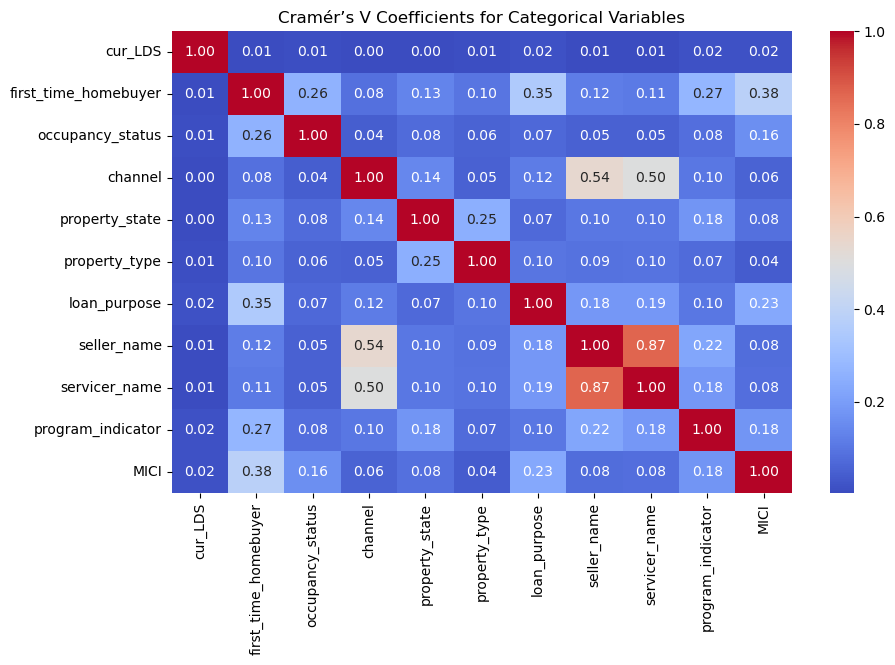

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cramers_v, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramér’s V Coefficients for Categorical Variables")
plt.show()

In [18]:
to_drop = set()  # Set to hold features to drop

# Iterate through the correlation matrix
for i in range(len(df_cramers_v.columns)):
    for j in range(i):
        if abs(df_cramers_v.iloc[i, j]) > 0.7:
            colname = df_cramers_v.columns[i]  # Get column name
            to_drop.add(colname)
df_cramers_v = df_cramers_v.drop(columns=to_drop, index=to_drop)
print(to_drop)

{'servicer_name'}


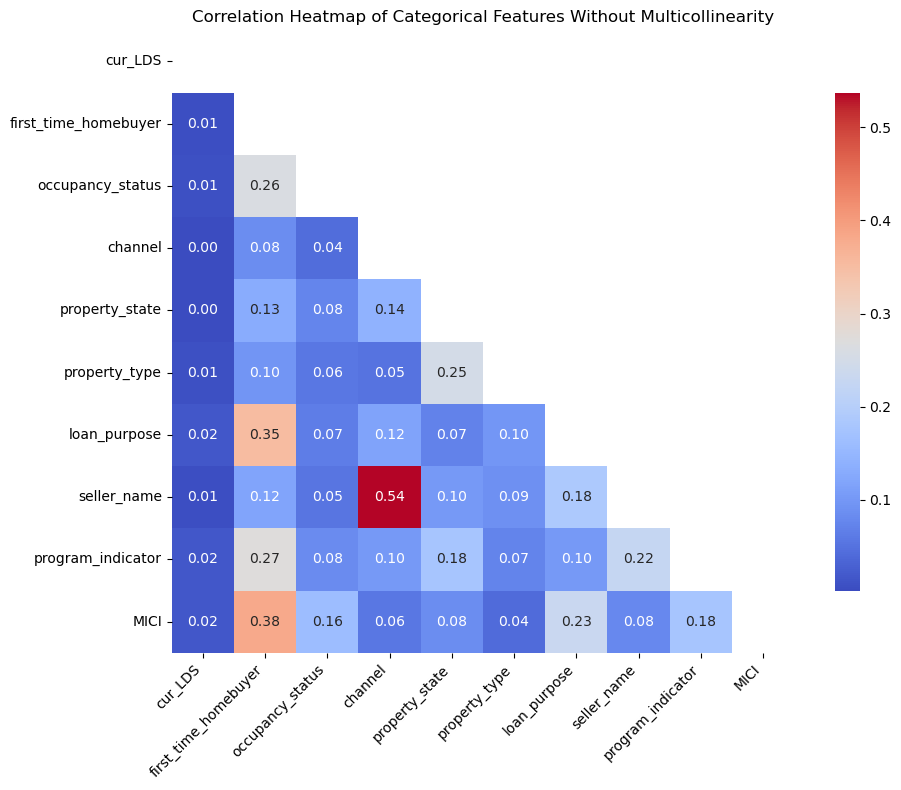

In [19]:
new_df_cramers_v = df_cramers_v.corr()
mask = np.triu(np.ones_like(df_cramers_v, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cramers_v, mask=mask, annot=True, fmt=".2f",
            cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Categorical Features Without Multicollinearity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7.0 Get target variable
`cur_LDS` is mapped to **True** and **False**, indicating the loan repayment behaviour of borrowers. Loans that are delinquent for **less than 60 days** fall into the **"True"** category, while those **60 days or more delinquent** fall into the **"False"** category.

In [20]:
ddf = ddf[['loan_sequence_num', 'monthly_reporting_period', 'cur_actual_UPB', 'cur_LDS', 'remaining_mths_to_legal_maturity',
       'cur_int_rate', 'cur_deferred_UPB', 'ELTV', 'credit_score', 'first_payment_date', 'first_time_homebuyer', 'MI(%)', 
       'num_of_units', 'occupancy_status', 'ori_DTI', 'channel', 'PPM_flag', 'amorisation_type', 'property_state', 'property_type', 
       'postal_code', 'loan_purpose', 'num_borrowers', 'seller_name', 'program_indicator', 'property_valuation_method', 'I/O_indicator', 
       'MICI', 'MSA', 'loan_age', "ori_UPB","quarter"]]

In [21]:
# Since desired features are obtained, load the dataset into RAM
df = ddf.compute()

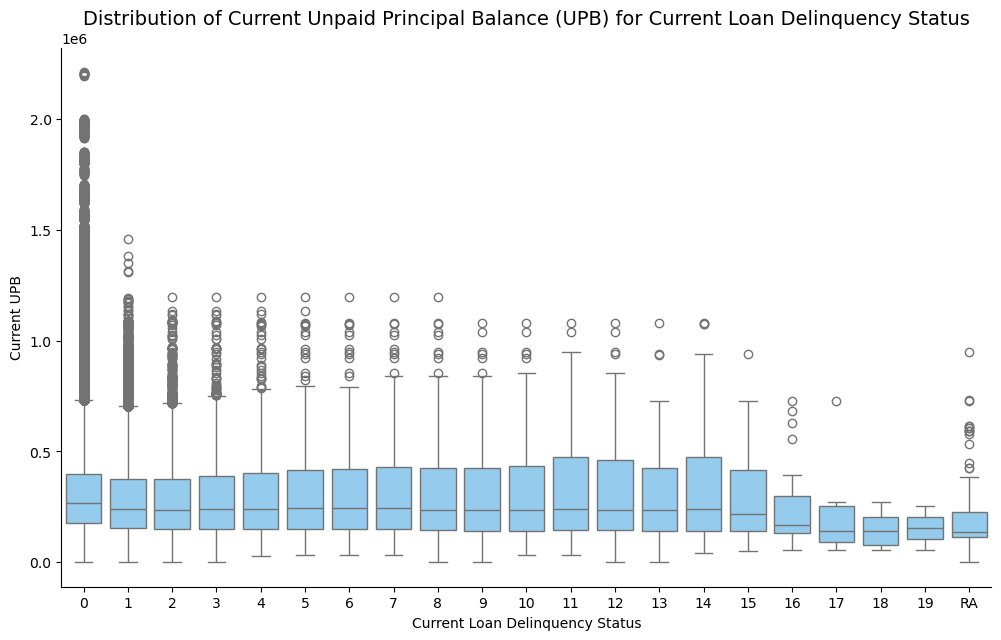

In [22]:
# To visualise the distribution of cur_actual_UPB across different cur_LDS
plt.figure(figsize=(12, 7))
sns.boxplot(x=df["cur_LDS"], y=df["cur_actual_UPB"], color="lightskyblue")
plt.xlabel("Current Loan Delinquency Status")
plt.ylabel("Current UPB")
plt.title("Distribution of Current Unpaid Principal Balance (UPB) for Current Loan Delinquency Status", size=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()


The box plot above reveals the distribution of the current loan amount based on different current loan delinquency statuses. Since the borrowers are continuously repaying their debts, their current delinquency status remains at 0. It was observed that most borrowers exhibit good repayment behaviour. Although they have high current loan amounts, they maintain a low current loan delinquency status, indicating that they are more likely to repay their loans. The categorisation for current delinquency status is shown below:
- 0 = Current, or less than 
30 days delinquent 
- 1 = 30-59 days 
delinquent 
- 2 = 60 – 89 days 
delinquent 
- 3 = 90 – 119 days 
delinquent 
- And so on… 
- RA = REO Acquisition

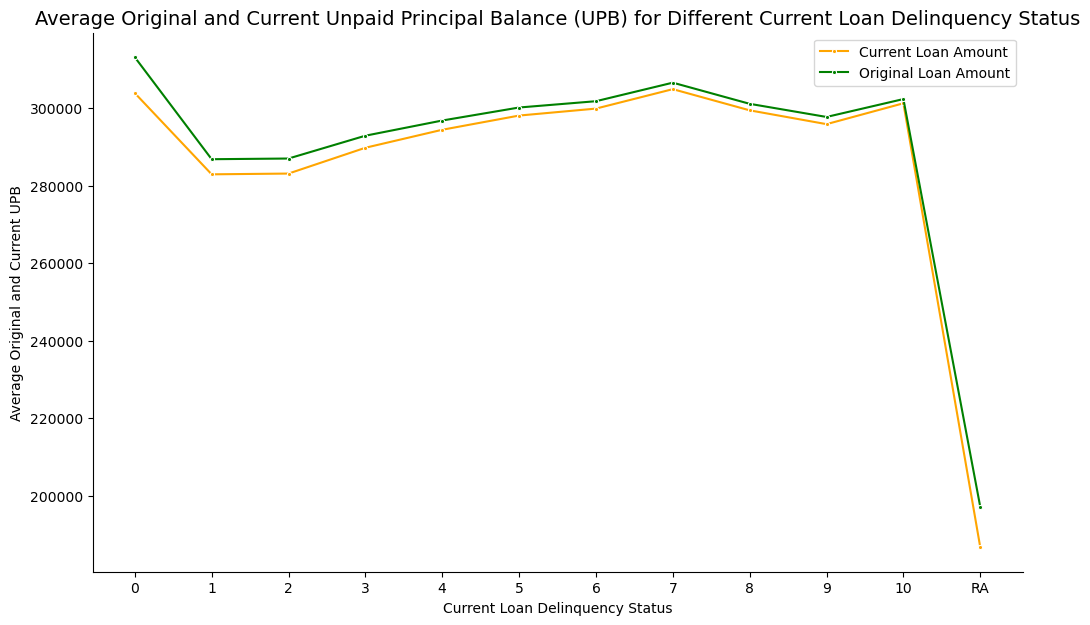

In [23]:
# Calculate mean cur_actual_UPB for different cur_LDS categories
mean_cur_upb_by_LDS = df.groupby("cur_LDS")["cur_actual_UPB"].mean()
mean_ori_upb_by_LDS = df.groupby("cur_LDS")["ori_UPB"].mean()

# Arrange x-axis in ascending order
x_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "RA"]
mean_cur_upb_by_LDS = mean_cur_upb_by_LDS.reindex([str(x) for x in x_order])
mean_ori_upb_by_LDS = mean_ori_upb_by_LDS.reindex([str(x) for x in x_order])

plt.figure(figsize=(12, 7))
sns.lineplot(x=mean_cur_upb_by_LDS.index, y=mean_cur_upb_by_LDS.values, marker='.', color="orange", label="Current Loan Amount")
sns.lineplot(x=mean_ori_upb_by_LDS.index, y=mean_ori_upb_by_LDS.values, marker='.', color="green", label="Original Loan Amount")
plt.xlabel("Current Loan Delinquency Status")
plt.ylabel("Average Original and Current UPB")
plt.title("Average Original and Current Unpaid Principal Balance (UPB) for Different Current Loan Delinquency Status", size=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

The statement above is supported by the plot showing the average original and current UPB for different current loan delinquency statuses. The original UPB (green) shifts downward, as does the current UPB (orange). It indicates a reduction in loan balances over time.

In [24]:
df["cur_LDS"] = df["cur_LDS"].astype(str).str.replace(" ", "", regex=True)
df['cur_LDS'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', 'RA'], dtype=object)

In [25]:
# To obtain the target variable
def get_target(col: str):
    if col == '0' or col == '1':
        return True
    else:
        return False
    
df['target'] = df['cur_LDS'].apply(get_target)

# Drop 'cur_LDS' to prevent data leakage during training
# Drop "ori_UPB"
df = df.drop(columns=["cur_LDS", "ori_UPB"])

df['target'].value_counts()

target
True     12940406
False       43378
Name: count, dtype: int64

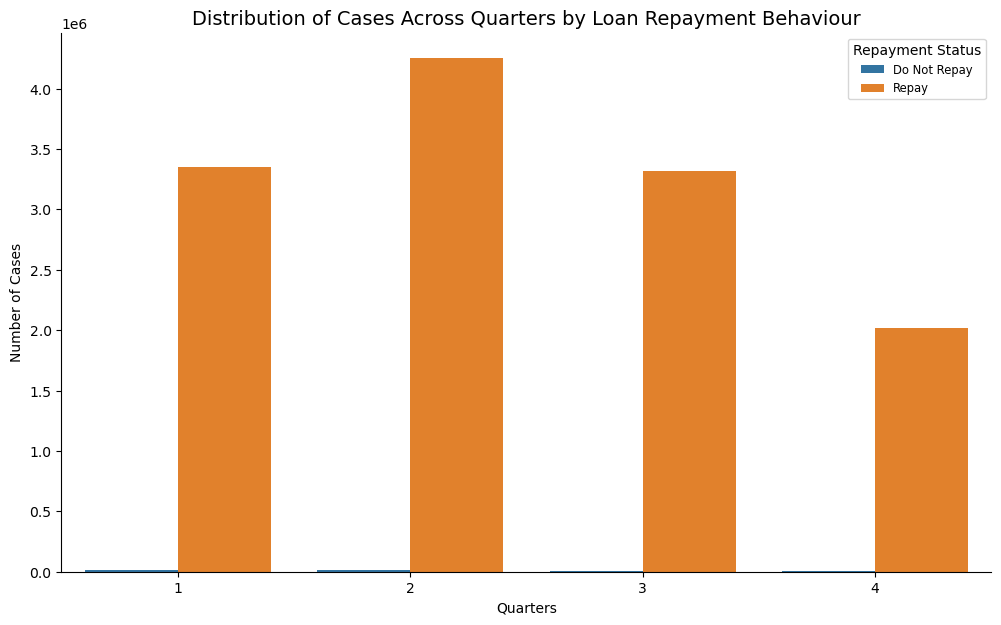

In [26]:
# To visualise the distribution across different cur_LDS
plt.figure(figsize=(12, 7))
sns.countplot(x=df["quarter"], hue=df["target"])
plt.xlabel("Quarters")
plt.ylabel("Number of Cases")
plt.title("Distribution of Cases Across Quarters by Loan Repayment Behaviour", size=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
label_mapping_target = {False: 'Do Not Repay', True: 'Repay'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_mapping_target[False], label_mapping_target[True]], 
           title='Repayment Status', loc="upper right", fontsize='small')
plt.show()

Severe class imbalance problem is found.

## 8.0 Check and remove duplicates

In [27]:
duplicate_count = df.duplicated().sum()
print("Number of duplicated rows: ", duplicate_count)
print("Data shape before duplicates removed: ", df.shape) 
df = df.drop_duplicates()
print("Data shape after duplicates removed: ", df.shape)

Number of duplicated rows:  0
Data shape before duplicates removed:  (12983784, 31)
Data shape after duplicates removed:  (12983784, 31)


## 9.0 Examine dataset

In [28]:
df.shape

(12983784, 31)

In [29]:
df.head(5)

,loan_sequence_num,monthly_reporting_period,cur_actual_UPB,remaining_mths_to_legal_maturity,cur_int_rate,cur_deferred_UPB,ELTV,credit_score,first_payment_date,first_time_homebuyer,...,num_borrowers,seller_name,program_indicator,property_valuation_method,I/O_indicator,MICI,MSA,loan_age,quarter,target
0,F23Q10000001,202304.0,104000.0,240.0,6.5,0.0,999.0,794.0,202305.0,N,...,1.0,Other sellers,9,2.0,N,7,45220.0,0.0,1,True
1,F23Q10000001,202305.0,104000.0,239.0,6.5,0.0,78.0,794.0,202305.0,N,...,1.0,Other sellers,9,2.0,N,7,45220.0,1.0,1,True
2,F23Q10000001,202306.0,103000.0,238.0,6.5,0.0,77.0,794.0,202305.0,N,...,1.0,Other sellers,9,2.0,N,7,45220.0,2.0,1,True
3,F23Q10000001,202307.0,100000.0,237.0,6.5,0.0,74.0,794.0,202305.0,N,...,1.0,Other sellers,9,2.0,N,7,45220.0,3.0,1,True
4,F23Q10000001,202308.0,99000.0,236.0,6.5,0.0,73.0,794.0,202305.0,N,...,1.0,Other sellers,9,2.0,N,7,45220.0,4.0,1,True


In [30]:
df.tail(5)

,loan_sequence_num,monthly_reporting_period,cur_actual_UPB,remaining_mths_to_legal_maturity,cur_int_rate,cur_deferred_UPB,ELTV,credit_score,first_payment_date,first_time_homebuyer,...,num_borrowers,seller_name,program_indicator,property_valuation_method,I/O_indicator,MICI,MSA,loan_age,quarter,target
1010227,F23Q40207366,202409.0,305000.0,360.0,6.375,0.0,35.0,807.0,202410.0,N,...,1.0,Other sellers,9,2.0,N,7,NaN,0.0,4,True
1010228,F23Q40207367,202409.0,72000.0,180.0,5.375,0.0,999.0,793.0,202410.0,N,...,2.0,Other sellers,9,2.0,N,7,48900.0,0.0,4,True
1010229,F23Q40207369,202409.0,329000.0,360.0,6.375,0.0,88.0,805.0,202410.0,N,...,1.0,Other sellers,9,2.0,N,7,39580.0,0.0,4,True
1010230,F23Q40207370,202409.0,372000.0,180.0,5.400,0.0,999.0,789.0,202410.0,N,...,2.0,Other sellers,9,2.0,N,7,28450.0,0.0,4,True
1010231,F23Q40207372,202409.0,700000.0,360.0,6.750,0.0,999.0,688.0,202410.0,N,...,2.0,Other sellers,9,2.0,N,7,44060.0,0.0,4,True


In [31]:
df.columns.values

array(['loan_sequence_num', 'monthly_reporting_period', 'cur_actual_UPB',
       'remaining_mths_to_legal_maturity', 'cur_int_rate',
       'cur_deferred_UPB', 'ELTV', 'credit_score', 'first_payment_date',
       'first_time_homebuyer', 'MI(%)', 'num_of_units',
       'occupancy_status', 'ori_DTI', 'channel', 'PPM_flag',
       'amorisation_type', 'property_state', 'property_type',
       'postal_code', 'loan_purpose', 'num_borrowers', 'seller_name',
       'program_indicator', 'property_valuation_method', 'I/O_indicator',
       'MICI', 'MSA', 'loan_age', 'quarter', 'target'], dtype=object)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12983784 entries, 0 to 1010231
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   loan_sequence_num                 string 
 1   monthly_reporting_period          float64
 2   cur_actual_UPB                    float64
 3   remaining_mths_to_legal_maturity  float64
 4   cur_int_rate                      float64
 5   cur_deferred_UPB                  float64
 6   ELTV                              float64
 7   credit_score                      float64
 8   first_payment_date                float64
 9   first_time_homebuyer              string 
 10  MI(%)                             float64
 11  num_of_units                      float64
 12  occupancy_status                  string 
 13  ori_DTI                           float64
 14  channel                           string 
 15  PPM_flag                          string 
 16  amorisation_type                  string

## 10.0 Save desired dataset

In [33]:
DATASET_DIR = "../datasets"
df.reset_index(drop=True).to_parquet(os.path.join(DATASET_DIR, "Single-Family-Loan-Level.parquet"))